In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Here the results from 'Adult EDA" file are going to be used

In [2]:
# %run "Adult EDA.ipynb"

In [3]:
adult_columns = [
    "Age",
    "Workclass",
    "final weight",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Income",
]

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
                 header = None, names = adult_columns)

In [4]:
df = df.drop(['Education-Num'], axis = 'columns')

## 1. Features preprocessing

First all variables have to be transformed to numerical format to feed them to Logit function:

In [5]:
_ = df['Income'].replace({' <=50K': 0, 
                             ' >50K': 1}, 
                            inplace = True)

'Sex' feature is also binary, we can convert it separately from other categorical features.

In [6]:
_ = df['Sex'].replace({' Male': 0, ' Female': 1}, 
                      inplace = True)

In [7]:
numerical_features_list = ['Age', 'Capital Gain', 'Capital Loss', 'Hours per week', 'final weight']
numerical_features_df = df[numerical_features_list]
numerical_features_df

,Age,Capital Gain,Capital Loss,Hours per week,final weight
0,39,2174,0,40,77516
1,50,0,0,13,83311
2,38,0,0,40,215646
3,53,0,0,40,234721
4,28,0,0,40,338409
...,...,...,...,...,...
32556,27,0,0,38,257302
32557,40,0,0,40,154374
32558,58,0,0,40,151910
32559,22,0,0,20,201490


In [8]:
X = df.drop(['Income'], axis = 'columns')
y = df['Income']

In [9]:
def reset_xy (df):
    X = df.drop(['Income', 'final weight', 'Occupation'], axis = 'columns')
    y = df['Income']
    return X, y

In [11]:
stand_scaler = StandardScaler()

In [12]:
def scale_numerical(numerical_features):
    X[numerical_features.columns.values] = stand_scaler.fit_transform(numerical_features.values)
    
scale_numerical(numerical_features_df)

In [13]:
X.sample()

,Age,Workclass,final weight,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
28846,0.030671,Private,-1.505115,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,0,-0.14592,-0.21666,-0.035429,United-States


In this dataset we have only one feature, where the order matters - Education. Let's transform it using OrdinalEncoder. 

In [14]:
edu_encoder = OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                                      ' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm', 
                                      ' Bachelors',' Masters',' Prof-school',' Doctorate']])

In [15]:
def encode_edu():
    X[["Education"]] = edu_encoder.fit_transform(df[["Education"]])
    
encode_edu()

For all the rest of categorical features the order does not matter, hense we can label encode them

In [16]:
categorical_features_df = X[['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Country']]

In [17]:
def encode_categorical(categorical_features_df):
    cat_df = categorical_features_df.apply(LabelEncoder().fit_transform)
    return cat_df

cat_df = encode_categorical(categorical_features_df)

Now we have to concatenate numerical and categorical features to one datadrame

In [18]:
def concat_num_and_cat(x, cat):
    X = x.drop(cat.columns, axis = 'columns')
    X = pd.concat([X, cat], axis=1, join='inner')
    return X

In [19]:
X = concat_num_and_cat(X, cat_df)
X.shape

(32561, 13)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

## Initial model without changes in data

In [21]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.398833
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26035
Method:                           MLE   Df Model:                           12
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.2788
Time:                        00:14:25   Log-Likelihood:                -10389.
converged:                       True   LL-Null:                       -14404.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.3914      0.020     19.617      0.000       0.352       0.430
final weight     

In [22]:
y_hat = model.predict(X_test)
prediction = list(map(round, y_hat))

print('Actual values', list(y_test.values)[:10])
print('Predictions :', prediction[:10])

Actual values [1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Predictions : [1, 1, 0, 0, 0, 0, 1, 0, 0, 0]


[[4677  290]
 [ 878  668]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4967
           1       0.70      0.43      0.53      1546

    accuracy                           0.82      6513
   macro avg       0.77      0.69      0.71      6513
weighted avg       0.81      0.82      0.80      6513



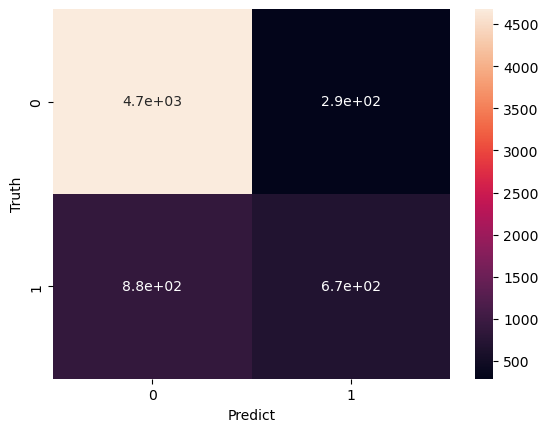

In [23]:
cm = confusion_matrix(y_test, prediction) 
s = sns.heatmap(cm, annot = True)
s.set(xlabel='Predict', ylabel='Truth')
print(cm)
print(classification_report(y_test, prediction))

According to Logit Regression Results there are 2 statistically insignificant features: final weight and occupation. Let's remove them for the following models

## Same model, but without 'final weight' and 'Occupation parameter

In [24]:
X, y = reset_xy(df)

In [25]:
num_no_fw = X[['Age', 'Capital Gain', 'Capital Loss', 'Hours per week']]
scale_numerical(num_no_fw)

In [26]:
encode_edu()
categorical_df = X[['Workclass', 'Marital Status', 'Relationship', 'Ethnic group', 'Country']]
cat_df = encode_categorical(categorical_df)

In [27]:
X = concat_num_and_cat(X, cat_df)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
X_train

,Age,Education,Sex,Capital Gain,Capital Loss,Hours per week,Workclass,Marital Status,Relationship,Ethnic group,Country
32024,1.057047,8.0,0,-0.145920,-0.216660,-0.035429,4,2,0,4,39
15261,-0.115955,12.0,0,-0.145920,-0.216660,0.612489,4,4,1,4,39
9125,-1.435581,9.0,0,-0.145920,-0.216660,-0.440378,4,4,3,4,39
27818,-0.482518,9.0,0,-0.145920,-0.216660,1.179417,4,4,2,4,7
6965,-0.482518,14.0,0,0.383247,-0.216660,-0.035429,4,2,0,4,39
...,...,...,...,...,...,...,...,...,...,...,...
7464,-0.849080,12.0,0,-0.145920,-0.216660,0.369519,2,2,0,4,39
7202,1.790173,12.0,0,-0.145920,4.689607,-0.683348,6,2,0,1,3
13772,1.936798,12.0,0,-0.145920,-0.216660,-2.060174,4,2,0,4,39
6937,-0.409205,5.0,0,-0.145920,-0.216660,-0.035429,4,2,0,4,39


In [29]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.399469
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26037
Method:                           MLE   Df Model:                           10
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.2800
Time:                        00:14:25   Log-Likelihood:                -10405.
converged:                       True   LL-Null:                       -14452.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.3822      0.020     19.136      0.000       0.343       0.421
Education        

In [30]:
y_hat = model.predict(X_test)
prediction = list(map(round, y_hat))

print('Actual values', list(y_test.values)[:10])
print('Predictions :', prediction[:10])

Actual values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predictions : [0, 0, 0, 1, 0, 1, 0, 0, 0, 0]


[[4672  337]
 [ 849  655]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      5009
           1       0.66      0.44      0.52      1504

    accuracy                           0.82      6513
   macro avg       0.75      0.68      0.71      6513
weighted avg       0.80      0.82      0.80      6513



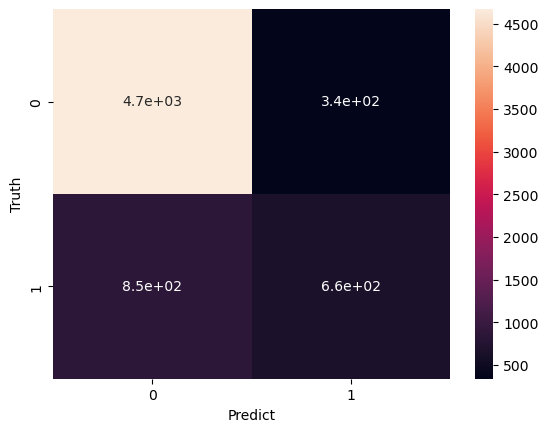

In [31]:
cm = confusion_matrix(y_test, prediction) 
s = sns.heatmap(cm, annot = True)
s.set(xlabel='Predict', ylabel='Truth')
print(cm)
print(classification_report(y_test, prediction))

The model still performs san in minority class detection

## Same model, but with Capital paremeters logged

In [32]:
X, y = reset_xy(df)

In [33]:
def capital_log():
    X['Capital Gain'] = np.log(1+ X['Capital Gain'])
    X['Capital Loss'] = np.log(1+ X['Capital Loss'])
    
capital_log()

In [34]:
num_no_capital = X[['Age', 'Hours per week']]
scale_numerical(num_no_capital)

In [35]:
X.head(2)

,Age,Workclass,Education,Marital Status,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0.030671,State-gov,Bachelors,Never-married,Not-in-family,White,0,7.684784,0.0,-0.035429,United-States
1,0.837109,Self-emp-not-inc,Bachelors,Married-civ-spouse,Husband,White,0,0.000000,0.0,-2.222153,United-States


In [36]:
encode_edu()
cat_df = encode_categorical(categorical_df)

In [37]:
X = concat_num_and_cat(X, cat_df)

In [38]:
X.head()

,Age,Education,Sex,Capital Gain,Capital Loss,Hours per week,Workclass,Marital Status,Relationship,Ethnic group,Country
0,0.030671,12.0,0,7.684784,0.0,-0.035429,7,4,1,4,39
1,0.837109,12.0,0,0.000000,0.0,-2.222153,6,2,0,4,39
2,-0.042642,8.0,0,0.000000,0.0,-0.035429,4,0,1,4,39
3,1.057047,6.0,0,0.000000,0.0,-0.035429,4,2,0,2,39
4,-0.775768,12.0,1,0.000000,0.0,-0.035429,4,2,5,2,5


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [40]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.415873
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26037
Method:                           MLE   Df Model:                           10
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.2468
Time:                        00:14:26   Log-Likelihood:                -10833.
converged:                       True   LL-Null:                       -14382.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.3760      0.019     19.323      0.000       0.338       0.414
Education        

In [41]:
y_hat = model.predict(X_test)
prediction = list(map(round, y_hat))
print('Actual values', list(y_test.values)[:10])
print('Predictions :', prediction[:10])

Actual values [0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Predictions : [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


[[4603  344]
 [ 923  643]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      4947
           1       0.65      0.41      0.50      1566

    accuracy                           0.81      6513
   macro avg       0.74      0.67      0.69      6513
weighted avg       0.79      0.81      0.79      6513



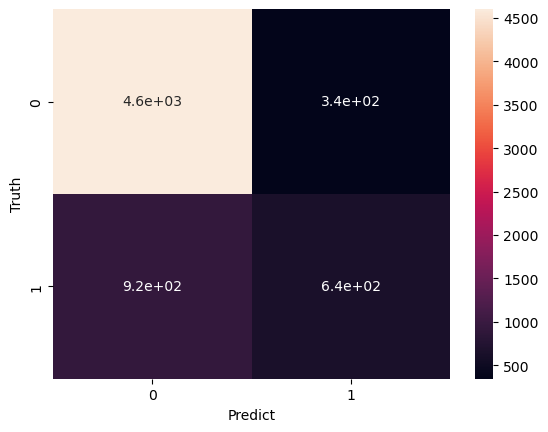

In [42]:
cm = confusion_matrix(y_test, prediction) 
s = sns.heatmap(cm, annot = True)
s.set(xlabel='Predict', ylabel='Truth')
print(cm)
print(classification_report(y_test, prediction))

## Logistic regression with previous data transformation

In [43]:
X, y = reset_xy(df)

For this modela all parameters, that have huge imbalance in their values, are changes to binary with categories:
1. Most popular alue or the feature
2. All other values together

In [44]:
def balance_predictors():
    X['Ethnic group'] = np.where(df['Ethnic group'] != ' White', 'Other', X['Ethnic group'])
    X['Country'] = np.where(df['Country'] != ' United-States', 'Other', X['Country'])
    X['Workclass'] = np.where(df['Workclass'] != ' Private', 'Other', X['Workclass'])
    
balance_predictors()
X.sample(3)

,Age,Workclass,Education,Marital Status,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
7503,51,Other,Doctorate,Married-civ-spouse,Husband,White,0,0,1887,40,United-States
14500,64,Private,HS-grad,Divorced,Unmarried,White,0,0,0,20,United-States
13387,29,Other,HS-grad,Married-civ-spouse,Husband,Other,0,0,0,40,United-States


In [45]:
encode_edu()

capital_log()

scale_numerical(num_no_fw)

In [46]:
X.sample()

,Age,Workclass,Education,Marital Status,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
1729,-0.55583,Private,10.0,Married-civ-spouse,Husband,White,0,-0.14592,-0.21666,0.12655,United-States


In [47]:
categorical_features_df = X[['Workclass', 'Marital Status', 'Relationship', 'Ethnic group', 'Country']]

In [48]:
cat_df = encode_categorical(categorical_features_df)

In [49]:
X = concat_num_and_cat(X, cat_df)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [51]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.417076
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26037
Method:                           MLE   Df Model:                           10
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.2437
Time:                        00:14:26   Log-Likelihood:                -10864.
converged:                       True   LL-Null:                       -14364.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.2862      0.019     14.752      0.000       0.248       0.324
Education        

In [52]:
y_hat = model.predict(X_test)
prediction = list(map(round, y_hat))

print('Actual values', list(y_test.values)[:10])
print('Predictions :', prediction[:10])

Actual values [0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
Predictions : [0, 1, 0, 1, 0, 1, 0, 1, 0, 0]


[[4612  320]
 [1004  577]]
              precision    recall  f1-score   support

           0       0.82      0.94      0.87      4932
           1       0.64      0.36      0.47      1581

    accuracy                           0.80      6513
   macro avg       0.73      0.65      0.67      6513
weighted avg       0.78      0.80      0.78      6513



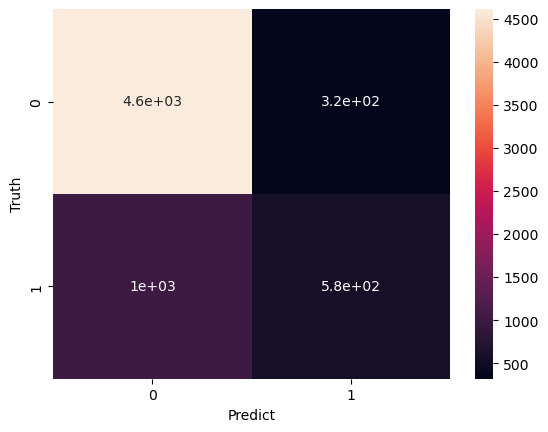

In [53]:
cm = confusion_matrix(y_test, prediction) 
s = sns.heatmap(cm, annot = True)
s.set(xlabel='Predict', ylabel='Truth')
print(cm)
print(classification_report(y_test, prediction))

## Oversampling target

In [54]:
count_class_0, count_class_1 = df['Income'].value_counts()

y0 = df[df['Income'] == 0]
y1 = df[df['Income'] == 1]

In [55]:
print(y0.shape)
print(y1.shape)

(24720, 14)
(7841, 14)


In [56]:
y1_over = y1.sample(count_class_0, replace = True)

In [57]:
df = pd.concat([y0, y1_over], axis = 0)

In [58]:
df.shape

(49440, 14)

In [59]:
X, y = reset_xy(df)

In [60]:
# balance_predictors()

In [61]:
encode_edu()

In [62]:
capital_log()

In [63]:
num_no_capital = X[['Age', 'Hours per week']]
scale_numerical(num_no_capital)

In [64]:
categorical_features_df = X[['Workclass', 'Marital Status', 'Relationship', 'Ethnic group', 'Country']]
cat_df = encode_categorical(categorical_features_df)

In [65]:
X = concat_num_and_cat(X, cat_df)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
X_train.sample(3)

,Age,Education,Sex,Capital Gain,Capital Loss,Hours per week,Workclass,Marital Status,Relationship,Ethnic group,Country
16620,-0.428837,12.0,1,8.444838,0.0,-0.178159,4,4,1,1,39
29053,1.040711,9.0,0,0.000000,0.0,-0.178159,4,2,0,4,39
22241,-1.047595,9.0,1,0.000000,0.0,0.232471,4,4,1,4,0


In [67]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.493922
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                39552
Model:                          Logit   Df Residuals:                    39541
Method:                           MLE   Df Model:                           10
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.2874
Time:                        00:14:27   Log-Likelihood:                -19536.
converged:                       True   LL-Null:                       -27415.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.4993      0.014     35.530      0.000       0.472       0.527
Education        

In [68]:
y_hat = model.predict(X_test)
prediction = list(map(round, y_hat))

print('Actual values', list(y_test.values)[:10])
print('Predictions :', prediction[:10])

Actual values [0, 0, 0, 0, 1, 0, 0, 0, 1, 1]
Predictions : [0, 0, 0, 1, 1, 0, 1, 0, 1, 0]


[[3667 1287]
 [1093 3841]]
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      4954
           1       0.75      0.78      0.76      4934

    accuracy                           0.76      9888
   macro avg       0.76      0.76      0.76      9888
weighted avg       0.76      0.76      0.76      9888



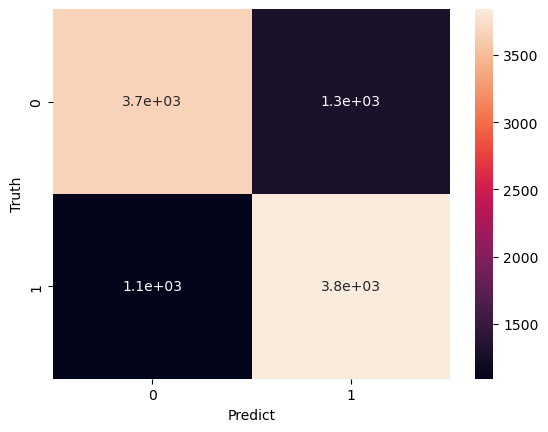

In [69]:
cm = confusion_matrix(y_test, prediction) 
s = sns.heatmap(cm, annot = True)
s.set(xlabel='Predict', ylabel='Truth')
print(cm)
print(classification_report(y_test, prediction))